In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

**Resources - **
1. https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/
2. https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/
3. https://towardsdatascience.com/understand-text-summarization-and-create-your-own-summarizer-in-python-b26a9f09fc70
4. https://github.com/aravindpai/How-to-build-own-text-summarizer-using-deep-learning

In [ ]:
summary = pd.read_csv('/kaggle/input/news-summary/news_summary.csv', encoding='iso-8859-1')
raw = pd.read_csv('/kaggle/input/news-summary/news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
pre1 =  raw.iloc[:,0:2].copy()
# pre1['head + text'] = pre1['headlines'].str.cat(pre1['text'], sep =" ") 

pre2 = summary.iloc[:,0:6].copy()
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [ ]:
pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'],pre2['headlines']],ignore_index = True)

In [ ]:
pre.head(2)

**Seq2Seq LSTM Modelling**
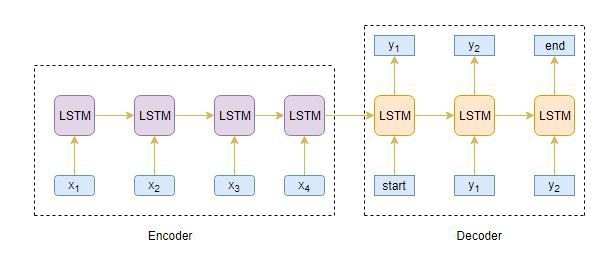

In [ ]:
#LSTM with Attention
#pip install keras-self-attention

pre['text'][:10]



> **Perform Data Cleansing**

In [ ]:
import re

#Removes non-alphabetic characters:
def text_strip(column):
    for row in column:
        
        #ORDER OF REGEX IS VERY VERY IMPORTANT!!!!!!
        
        row=re.sub("(\\t)", ' ', str(row)).lower() #remove escape charecters
        row=re.sub("(\\r)", ' ', str(row)).lower() 
        row=re.sub("(\\n)", ' ', str(row)).lower()
        
        row=re.sub("(__+)", ' ', str(row)).lower()   #remove _ if it occors more than one time consecutively
        row=re.sub("(--+)", ' ', str(row)).lower()   #remove - if it occors more than one time consecutively
        row=re.sub("(~~+)", ' ', str(row)).lower()   #remove ~ if it occors more than one time consecutively
        row=re.sub("(\+\++)", ' ', str(row)).lower()   #remove + if it occors more than one time consecutively
        row=re.sub("(\.\.+)", ' ', str(row)).lower()   #remove . if it occors more than one time consecutively
        
        row=re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(row)).lower() #remove <>()|&©ø"',;?~*!
        
        row=re.sub("(mailto:)", ' ', str(row)).lower() #remove mailto:
        row=re.sub(r"(\\x9\d)", ' ', str(row)).lower() #remove \x9* in text
        row=re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(row)).lower() #replace INC nums to INC_NUM
        row=re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM', str(row)).lower() #replace CM# and CHG# to CM_NUM
        
        
        row=re.sub("(\.\s+)", ' ', str(row)).lower() #remove full stop at end of words(not between)
        row=re.sub("(\-\s+)", ' ', str(row)).lower() #remove - at end of words(not between)
        row=re.sub("(\:\s+)", ' ', str(row)).lower() #remove : at end of words(not between)
        
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces
        
        #Replace any url as such https://abc.xyz.net/browse/sdf-5327 ====> abc.xyz.net
        try:
            url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(row))
            repl_url = url.group(3)
            row = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)',repl_url, str(row))
        except:
            pass #there might be emails with no url in them
        

        
        row = re.sub("(\s+)",' ',str(row)).lower() #remove multiple spaces
        
        #Should always be last
        row=re.sub("(\s+.\s+)", ' ', str(row)).lower() #remove any single charecters hanging between 2 spaces

        
        
        yield row




In [ ]:
brief_cleaning1 = text_strip(pre['text'])
brief_cleaning2 = text_strip(pre['summary'])

In [ ]:
from time import time
import spacy
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:
#If data loss seems to be happening(i.e len(text) = 50 instead of 75 etc etc) in this cell , decrease the batch_size parametre 

t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
text = [str(doc) for doc in nlp.pipe(brief_cleaning1, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#Taking advantage of spaCy .pipe() method to speed-up the cleaning process:


t = time()

#Batch the data points into 5000 and run on all cores for faster preprocessing
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(brief_cleaning2, batch_size=5000, n_threads=-1)]

#Takes 7-8 mins
print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
text[0]

In [ ]:
summary[0]

In [ ]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

In [ ]:
text_count = []
summary_count = []

In [ ]:
for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

In [ ]:
graph_df= pd.DataFrame()
graph_df['text']=text_count
graph_df['summary']=summary_count

In [ ]:
import matplotlib.pyplot as plt

graph_df.hist(bins = 5)
plt.show()

In [ ]:
#Check how much % of summary have 0-15 words
cnt=0
for i in pre['cleaned_summary']:
    if(len(i.split())<=15):
        cnt=cnt+1
print(cnt/len(pre['cleaned_summary']))

In [ ]:
#Check how much % of text have 0-70 words
cnt=0
for i in pre['cleaned_text']:
    if(len(i.split())<=100):
        cnt=cnt+1
print(cnt/len(pre['cleaned_text']))

In [ ]:
#Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len=100
max_summary_len=15

In [ ]:
#Select the Summaries and Text between max len defined above

cleaned_text =np.array(pre['cleaned_text'])
cleaned_summary=np.array(pre['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre.head(2)

In [ ]:
#Add sostok and eostok at 
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
post_pre.head(2)

**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
#Lets tokenize the text to get the vocab count , you can use Spacy here also

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [ ]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* tot_cnt gives the size of vocabulary (which means every unique words in the text)

* cnt gives me the no. of rare words whose count falls below threshold

* tot_cnt - cnt gives me the top most common words

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [ ]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

In [ ]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

We will now remove "Summary" i.e Y (both train and val) which has only _START_ and _END_

In [ ]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

print("Size of vocabulary from the w2v model = {}".format(x_voc))

K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


**Visualize the model learning**

In [ ]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

**Next, let’s build the dictionary to convert the index to word for target and source vocabulary:**

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

**We are defining a function below which is the implementation of the inference process**

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

**Let us define the functions to convert an integer sequence to a word sequence for summary as well as the reviews:**


In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

**Run the model over the data to see the results**

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

**Run the model over Validation Set**

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_text_len)))
    print("\n")

**Run the model over our own test article**

In [ ]:
test_art = """ """

**Vectorizing the news article now**
* 
**Note that during vectorization , if the word was not present in the bag of words which were converted to tokens , it returns the word vector as 0**

In [ ]:

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(test_art))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
test_art_seq    =   x_tokenizer.texts_to_sequences(test_art) 

#padding zero upto maximum length
test_art    =   pad_sequences(test_art_seq,  maxlen=max_text_len, padding='post')

In [ ]:
print(test_art.shape)
print(test_art)

**Run the model over vectorized text**

In [ ]:
for i in range(0,100):
    print("Review:",seq2text(test_art[i]))
    print("Original summary:",seq2summary(test_art[i]))
    print("Predicted summary:",decode_sequence(test_art[i].reshape(1,max_text_len)))
    print("\n")